In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import random
import operator
pd.options.display.max_rows = None

In [2]:
#definimos la clase board
class board():
    def __init__(self,n=10):
        self.n=n#dimensiones de la cuadricula nxn
        self.current_state=(0,0)#posicion inicial del agente
        self.reward=0#recompensa obtenida por el agente
        self.grid=np.zeros((11,11)) #almacenamos el gridworld como una matriz 3x7
        self.__values=np.zeros((11,11))#creamos una matriz con las mismas dimensiones que el grod world
        self.grid[5,0:2]=np.nan#definimos aqui 
        self.grid[5,3:8]=np.nan#las paredes de los
        self.grid[5,9:11]=np.nan#3 cuartos
        self.grid[0:2,5]=np.nan#definimos aqui 
        self.grid[3:8,5]=np.nan#las paredes de los
        self.grid[9:11,5]=np.nan#3 cuartos
        #para almacenar los valores de los estados(entiendase valores como los que se calculan de la ecuación de 
        #Bellman)
        self.__values[0,2]=1#Asignamos una recompensa de 1 a la salida del laberinto
        
        
        
        
        
        self._is_term=np.zeros((11,11))
        self._is_term[0,2]=1 #asignamos como casilla terminal la salida del laberinto
        
    def get_current_state(self):
        return self.current_state
    def get_posible_actions(self, estado_actual):
        fila, columna=estado_actual #desempacamos la fila y la columna
        n_filas,n_columnas=self.grid.shape
        #del estado actual
        acciones=[]
        n=self.n
        if self.is_terminal(estado_actual)==True:
            acciones.append("Salir")
            return acciones
        #verificar si up es posible:
        if (fila!=0) and (np.isnan(self.grid[fila-1,columna])==False):#se puede mover hacia arriba
            #si no esta en la fila cero y ademas en la casilla superior no hay obstaculo
            acciones.append("up")
        #verificar si down es posible
        if (fila!=n_filas-1) and (np.isnan(self.grid[fila+1,columna])==False):#se puede mover hacia abajo
            #si no esta en la ultima fila y ademas la casilla de abajo no es obstaculo
            acciones.append("down")
        #verificar si right es posible
        if (columna!=n_columnas-1) and (np.isnan(self.grid[fila,columna+1])==False):#se puede mover hacia la
            #derecha si no esta en la ultima columna y ademas la casilla de la derecha no es obstaculo
            acciones.append("right")
        if (columna!=0) and (np.isnan(self.grid[fila,columna-1])==False):#se puede mover hacia la izquierda
            #si no esta en la primera coulumna y ademas la casilla de la izquiera no es un obstaculo
            acciones.append("left")
        return acciones
    
    def do_action(self, action):
        fila_actual, columna_actual=self.current_state
        acciones_posibles=self.get_posible_actions((fila_actual,columna_actual))
        if action not in acciones_posibles:
            return (0,self.current_state)
        
        
        
        if action=="Salir":
            return(self.__values[fila_actual,columna_actual],"END")
              
        if action=="up":#moverse hacia arriba, restar 1 al valor de la fila actual
            self.current_state=(fila_actual-1,columna_actual)
        elif action=="down":#moverse hacia arriba, sumar 1 al valor de la fila actual
            self.current_state=(fila_actual+1,columna_actual)
        elif action=="right":#moverse hacia derecha, sumar 1 al valor de la columna actual
            self.current_state=(fila_actual,columna_actual+1)
        else:
            #moverse hacia izquierda, restar 1 al valor de la columna actual
            self.current_state=(fila_actual,columna_actual-1)
        return (self.grid[self.current_state[0],self.current_state[1]],self.current_state)   
    def reset(self):#reiniciar
        self.current_state=(0,0)
        self.reward=0
    def is_terminal(self,estado):
        if (self._is_term[estado[0],estado[1]]==1) | (self._is_term[estado[0],estado[1]]==-1):
            return True
        else:
            return False
        
    #HASTA AQUI EL PUNTO I) DE LA TAREA, QUE CORRESPONDIA A LA DEFINICION DEL AMBIENTE.
    #PARA LA PARTE II) DE LA TAREA, QUE ES CONSTRUIR EL MARKOV DECISSION PROCESS, DEFINIMOS OTRO
    #METODO, QUE LLAMÉ MDP
    def grilla(self):
        colormap = colors.ListedColormap(["red","green","blue"])
        plt.figure(figsize=(5,5))
        plt.imshow(self.grid,cmap=colormap)
        plt.title("Grilla para juego: en verde las casillas sin recompensa, en blanco, los obstaculos, en azul la casilla objetivo, y en rojo las casillas trampa")
        plt.show()
                
    


        
            

In [3]:
class Q_LEARNING():
    def __init__(self,env,epsilon,gamma,alpha):
        self.epsilon=epsilon
        self.gamma=gamma
        self.alpha=alpha
        self.env=env
        #creamos el atributo Q para guardar los valores de las acciones y los estados
        #Inicalizalizamos un diccionario para almacenar los q_valores de las acciones y estados:
        self.Q={}
        filas,columnas=self.env.grid.shape
        acciones=["up","right","left","down","Salir"]
        for i in range(filas):
            for j in range(columnas):
                if np.isnan(self.env.grid[i,j])==False:
                    if self.env.is_terminal((i,j))==True:
                        self.Q[(i,j)]={"Salir":0}
                    else:
                        self.Q[(i,j)]={accion:0 for accion in acciones}
                    
        #inicializamos una lista con todos los posibles estados:
        self.posibles_estados=[]
        for i in range(filas):
            for j in range(columnas):
                if np.isnan(self.env.grid[i,j])==False:
                    self.posibles_estados.append((i,j))
        
        
        
    def choose_action(self,estado):
        #seleccionamos la accion maxima
        accion= max(self.Q[estado], key=self.Q[estado].get)
        #seleccionamos la lista de todas las posibles acciones:
        posibles_acciones=list(self.Q[estado].keys())
        #creamos una lista con las posibles acciones diferentes a la greedy:
        posibles_acciones_diferentes=[]
        for element in posibles_acciones:
            if element!=accion:
                posibles_acciones_diferentes.append(element)
        #ahora escogemos entre seguir la greedy o no:
        
        decision=np.random.choice([0,1],p=[1-self.epsilon,self.epsilon])#0 si sigue la politica greedy, 1 si no
        if decision==0:
            return accion#si salio seguir la greedy, devuelve la accion greedy
        else:
            try:
                return random.choice(posibles_acciones_diferentes)#si salio la opcion de explorar, devuelve una accion 
            except IndexError:
                return accion
                #aleatoria diferente a la greedy
    def Q_max(self,estado):#devuelve el valor del maximo estado al que se puede llegar desde el estado dado:
        accion= max(self.Q[estado], key=self.Q[estado].get)
        return self.Q[estado][accion]
        
                
    def action_function(self,estado1, accion1, recompensa, estado2):
        #implementa el calculo del q_valor de la accion segun el agoritmo de Q_learning
        
        if estado2=="END":
            self.Q[estado1][accion1]=self.Q[estado1][accion1]+self.alpha*(recompensa-
                                                                     self.Q[estado1][accion1])
        else:
            Q_max=self.Q_max(estado2)
            self.Q[estado1][accion1]=self.Q[estado1][accion1]+self.alpha*(recompensa+self.gamma*Q_max-self.Q[estado1][accion1])
    def episodio(self):
        #inicializar un estado S:
        S_1=random.choice(self.posibles_estados)
        
        terminado=False#creamos una variable para saber si el episodio esta terminado
        while terminado==False:
            
            if self.env.is_terminal(S_1)==True:
                #print(S_1)
                recompensa,S_2=self.env.do_action("Salir")#ejecutamos la accion 1 desde el estado 1, y obtenemos la recompensa
                #print("Salir")
                #print(recompensa)
                self.action_function(S_1,"Salir",recompensa,S_2)
                terminado=True
            else:
                           
                #print(S_1)
                accion1=self.choose_action(S_1)#calculamos la accion a tomar para estado S1
                #print(accion1)
                self.env.current_state=S_1
                recompensa,S_2=self.env.do_action(accion1)#ejecutamos la accion 1 desde el estado 1, y obtenemos la recompensa
                #print(recompensa)
                #y quedamos en el estado 2
                
                #finalmente, ejecutamos la funcion action_function:
                self.action_function(S_1,accion1,recompensa,S_2)
                #ahora cambiamos S1 a S2 para el siguiente step

                S_1=S_2
                #verficamos si es terminal
                if accion1=="Salir":
                    terminado=True
    def politica_optima(self,episodios):
        #ejecuta los episodios:
        for i in range(episodios):
            self.episodio()#ejecuta la funcion episodio
            print(f"episodio {i}")
        #ahora calculamos la politica optima
        filas,columnas=self.env.grid.shape#obtenemos el numero de filas y columnas
        decisiones=[]
        self.epsilon=0#ahora solo seguimos politicas greedy
        for i in range(filas):
            lista_fila=[self.choose_action((i,j)) if np.isnan(self.env.grid[i,j])==False else None for j in range(columnas) ]
            decisiones.append(lista_fila)
        return pd.DataFrame(decisiones)
   
        
        
        
        
            
        

In [4]:
my_board=board()


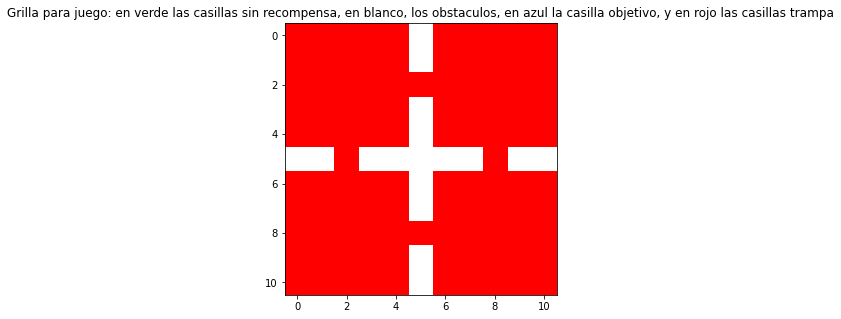

In [5]:
my_board.grilla()

In [6]:
my_q_learning=Q_LEARNING(my_board,0.5,0.2,0.1)

In [7]:
my_q_learning.politica_optima(10000)

episodio 0
episodio 1
episodio 2
episodio 3
episodio 4
episodio 5
episodio 6
episodio 7
episodio 8
episodio 9
episodio 10
episodio 11
episodio 12
episodio 13
episodio 14
episodio 15
episodio 16
episodio 17
episodio 18
episodio 19
episodio 20
episodio 21
episodio 22
episodio 23
episodio 24
episodio 25
episodio 26
episodio 27
episodio 28
episodio 29
episodio 30
episodio 31
episodio 32
episodio 33
episodio 34
episodio 35
episodio 36
episodio 37
episodio 38
episodio 39
episodio 40
episodio 41
episodio 42
episodio 43
episodio 44
episodio 45
episodio 46
episodio 47
episodio 48
episodio 49
episodio 50
episodio 51
episodio 52
episodio 53
episodio 54
episodio 55
episodio 56
episodio 57
episodio 58
episodio 59
episodio 60
episodio 61
episodio 62
episodio 63
episodio 64
episodio 65
episodio 66
episodio 67
episodio 68
episodio 69
episodio 70
episodio 71
episodio 72
episodio 73
episodio 74
episodio 75
episodio 76
episodio 77
episodio 78
episodio 79
episodio 80
episodio 81
episodio 82
episodio 83
ep

episodio 830
episodio 831
episodio 832
episodio 833
episodio 834
episodio 835
episodio 836
episodio 837
episodio 838
episodio 839
episodio 840
episodio 841
episodio 842
episodio 843
episodio 844
episodio 845
episodio 846
episodio 847
episodio 848
episodio 849
episodio 850
episodio 851
episodio 852
episodio 853
episodio 854
episodio 855
episodio 856
episodio 857
episodio 858
episodio 859
episodio 860
episodio 861
episodio 862
episodio 863
episodio 864
episodio 865
episodio 866
episodio 867
episodio 868
episodio 869
episodio 870
episodio 871
episodio 872
episodio 873
episodio 874
episodio 875
episodio 876
episodio 877
episodio 878
episodio 879
episodio 880
episodio 881
episodio 882
episodio 883
episodio 884
episodio 885
episodio 886
episodio 887
episodio 888
episodio 889
episodio 890
episodio 891
episodio 892
episodio 893
episodio 894
episodio 895
episodio 896
episodio 897
episodio 898
episodio 899
episodio 900
episodio 901
episodio 902
episodio 903
episodio 904
episodio 905
episodio 906

episodio 1617
episodio 1618
episodio 1619
episodio 1620
episodio 1621
episodio 1622
episodio 1623
episodio 1624
episodio 1625
episodio 1626
episodio 1627
episodio 1628
episodio 1629
episodio 1630
episodio 1631
episodio 1632
episodio 1633
episodio 1634
episodio 1635
episodio 1636
episodio 1637
episodio 1638
episodio 1639
episodio 1640
episodio 1641
episodio 1642
episodio 1643
episodio 1644
episodio 1645
episodio 1646
episodio 1647
episodio 1648
episodio 1649
episodio 1650
episodio 1651
episodio 1652
episodio 1653
episodio 1654
episodio 1655
episodio 1656
episodio 1657
episodio 1658
episodio 1659
episodio 1660
episodio 1661
episodio 1662
episodio 1663
episodio 1664
episodio 1665
episodio 1666
episodio 1667
episodio 1668
episodio 1669
episodio 1670
episodio 1671
episodio 1672
episodio 1673
episodio 1674
episodio 1675
episodio 1676
episodio 1677
episodio 1678
episodio 1679
episodio 1680
episodio 1681
episodio 1682
episodio 1683
episodio 1684
episodio 1685
episodio 1686
episodio 1687
episod

episodio 2355
episodio 2356
episodio 2357
episodio 2358
episodio 2359
episodio 2360
episodio 2361
episodio 2362
episodio 2363
episodio 2364
episodio 2365
episodio 2366
episodio 2367
episodio 2368
episodio 2369
episodio 2370
episodio 2371
episodio 2372
episodio 2373
episodio 2374
episodio 2375
episodio 2376
episodio 2377
episodio 2378
episodio 2379
episodio 2380
episodio 2381
episodio 2382
episodio 2383
episodio 2384
episodio 2385
episodio 2386
episodio 2387
episodio 2388
episodio 2389
episodio 2390
episodio 2391
episodio 2392
episodio 2393
episodio 2394
episodio 2395
episodio 2396
episodio 2397
episodio 2398
episodio 2399
episodio 2400
episodio 2401
episodio 2402
episodio 2403
episodio 2404
episodio 2405
episodio 2406
episodio 2407
episodio 2408
episodio 2409
episodio 2410
episodio 2411
episodio 2412
episodio 2413
episodio 2414
episodio 2415
episodio 2416
episodio 2417
episodio 2418
episodio 2419
episodio 2420
episodio 2421
episodio 2422
episodio 2423
episodio 2424
episodio 2425
episod

episodio 3055
episodio 3056
episodio 3057
episodio 3058
episodio 3059
episodio 3060
episodio 3061
episodio 3062
episodio 3063
episodio 3064
episodio 3065
episodio 3066
episodio 3067
episodio 3068
episodio 3069
episodio 3070
episodio 3071
episodio 3072
episodio 3073
episodio 3074
episodio 3075
episodio 3076
episodio 3077
episodio 3078
episodio 3079
episodio 3080
episodio 3081
episodio 3082
episodio 3083
episodio 3084
episodio 3085
episodio 3086
episodio 3087
episodio 3088
episodio 3089
episodio 3090
episodio 3091
episodio 3092
episodio 3093
episodio 3094
episodio 3095
episodio 3096
episodio 3097
episodio 3098
episodio 3099
episodio 3100
episodio 3101
episodio 3102
episodio 3103
episodio 3104
episodio 3105
episodio 3106
episodio 3107
episodio 3108
episodio 3109
episodio 3110
episodio 3111
episodio 3112
episodio 3113
episodio 3114
episodio 3115
episodio 3116
episodio 3117
episodio 3118
episodio 3119
episodio 3120
episodio 3121
episodio 3122
episodio 3123
episodio 3124
episodio 3125
episod

episodio 3797
episodio 3798
episodio 3799
episodio 3800
episodio 3801
episodio 3802
episodio 3803
episodio 3804
episodio 3805
episodio 3806
episodio 3807
episodio 3808
episodio 3809
episodio 3810
episodio 3811
episodio 3812
episodio 3813
episodio 3814
episodio 3815
episodio 3816
episodio 3817
episodio 3818
episodio 3819
episodio 3820
episodio 3821
episodio 3822
episodio 3823
episodio 3824
episodio 3825
episodio 3826
episodio 3827
episodio 3828
episodio 3829
episodio 3830
episodio 3831
episodio 3832
episodio 3833
episodio 3834
episodio 3835
episodio 3836
episodio 3837
episodio 3838
episodio 3839
episodio 3840
episodio 3841
episodio 3842
episodio 3843
episodio 3844
episodio 3845
episodio 3846
episodio 3847
episodio 3848
episodio 3849
episodio 3850
episodio 3851
episodio 3852
episodio 3853
episodio 3854
episodio 3855
episodio 3856
episodio 3857
episodio 3858
episodio 3859
episodio 3860
episodio 3861
episodio 3862
episodio 3863
episodio 3864
episodio 3865
episodio 3866
episodio 3867
episod

episodio 4630
episodio 4631
episodio 4632
episodio 4633
episodio 4634
episodio 4635
episodio 4636
episodio 4637
episodio 4638
episodio 4639
episodio 4640
episodio 4641
episodio 4642
episodio 4643
episodio 4644
episodio 4645
episodio 4646
episodio 4647
episodio 4648
episodio 4649
episodio 4650
episodio 4651
episodio 4652
episodio 4653
episodio 4654
episodio 4655
episodio 4656
episodio 4657
episodio 4658
episodio 4659
episodio 4660
episodio 4661
episodio 4662
episodio 4663
episodio 4664
episodio 4665
episodio 4666
episodio 4667
episodio 4668
episodio 4669
episodio 4670
episodio 4671
episodio 4672
episodio 4673
episodio 4674
episodio 4675
episodio 4676
episodio 4677
episodio 4678
episodio 4679
episodio 4680
episodio 4681
episodio 4682
episodio 4683
episodio 4684
episodio 4685
episodio 4686
episodio 4687
episodio 4688
episodio 4689
episodio 4690
episodio 4691
episodio 4692
episodio 4693
episodio 4694
episodio 4695
episodio 4696
episodio 4697
episodio 4698
episodio 4699
episodio 4700
episod

episodio 5385
episodio 5386
episodio 5387
episodio 5388
episodio 5389
episodio 5390
episodio 5391
episodio 5392
episodio 5393
episodio 5394
episodio 5395
episodio 5396
episodio 5397
episodio 5398
episodio 5399
episodio 5400
episodio 5401
episodio 5402
episodio 5403
episodio 5404
episodio 5405
episodio 5406
episodio 5407
episodio 5408
episodio 5409
episodio 5410
episodio 5411
episodio 5412
episodio 5413
episodio 5414
episodio 5415
episodio 5416
episodio 5417
episodio 5418
episodio 5419
episodio 5420
episodio 5421
episodio 5422
episodio 5423
episodio 5424
episodio 5425
episodio 5426
episodio 5427
episodio 5428
episodio 5429
episodio 5430
episodio 5431
episodio 5432
episodio 5433
episodio 5434
episodio 5435
episodio 5436
episodio 5437
episodio 5438
episodio 5439
episodio 5440
episodio 5441
episodio 5442
episodio 5443
episodio 5444
episodio 5445
episodio 5446
episodio 5447
episodio 5448
episodio 5449
episodio 5450
episodio 5451
episodio 5452
episodio 5453
episodio 5454
episodio 5455
episod

episodio 6093
episodio 6094
episodio 6095
episodio 6096
episodio 6097
episodio 6098
episodio 6099
episodio 6100
episodio 6101
episodio 6102
episodio 6103
episodio 6104
episodio 6105
episodio 6106
episodio 6107
episodio 6108
episodio 6109
episodio 6110
episodio 6111
episodio 6112
episodio 6113
episodio 6114
episodio 6115
episodio 6116
episodio 6117
episodio 6118
episodio 6119
episodio 6120
episodio 6121
episodio 6122
episodio 6123
episodio 6124
episodio 6125
episodio 6126
episodio 6127
episodio 6128
episodio 6129
episodio 6130
episodio 6131
episodio 6132
episodio 6133
episodio 6134
episodio 6135
episodio 6136
episodio 6137
episodio 6138
episodio 6139
episodio 6140
episodio 6141
episodio 6142
episodio 6143
episodio 6144
episodio 6145
episodio 6146
episodio 6147
episodio 6148
episodio 6149
episodio 6150
episodio 6151
episodio 6152
episodio 6153
episodio 6154
episodio 6155
episodio 6156
episodio 6157
episodio 6158
episodio 6159
episodio 6160
episodio 6161
episodio 6162
episodio 6163
episod

episodio 6811
episodio 6812
episodio 6813
episodio 6814
episodio 6815
episodio 6816
episodio 6817
episodio 6818
episodio 6819
episodio 6820
episodio 6821
episodio 6822
episodio 6823
episodio 6824
episodio 6825
episodio 6826
episodio 6827
episodio 6828
episodio 6829
episodio 6830
episodio 6831
episodio 6832
episodio 6833
episodio 6834
episodio 6835
episodio 6836
episodio 6837
episodio 6838
episodio 6839
episodio 6840
episodio 6841
episodio 6842
episodio 6843
episodio 6844
episodio 6845
episodio 6846
episodio 6847
episodio 6848
episodio 6849
episodio 6850
episodio 6851
episodio 6852
episodio 6853
episodio 6854
episodio 6855
episodio 6856
episodio 6857
episodio 6858
episodio 6859
episodio 6860
episodio 6861
episodio 6862
episodio 6863
episodio 6864
episodio 6865
episodio 6866
episodio 6867
episodio 6868
episodio 6869
episodio 6870
episodio 6871
episodio 6872
episodio 6873
episodio 6874
episodio 6875
episodio 6876
episodio 6877
episodio 6878
episodio 6879
episodio 6880
episodio 6881
episod

episodio 7546
episodio 7547
episodio 7548
episodio 7549
episodio 7550
episodio 7551
episodio 7552
episodio 7553
episodio 7554
episodio 7555
episodio 7556
episodio 7557
episodio 7558
episodio 7559
episodio 7560
episodio 7561
episodio 7562
episodio 7563
episodio 7564
episodio 7565
episodio 7566
episodio 7567
episodio 7568
episodio 7569
episodio 7570
episodio 7571
episodio 7572
episodio 7573
episodio 7574
episodio 7575
episodio 7576
episodio 7577
episodio 7578
episodio 7579
episodio 7580
episodio 7581
episodio 7582
episodio 7583
episodio 7584
episodio 7585
episodio 7586
episodio 7587
episodio 7588
episodio 7589
episodio 7590
episodio 7591
episodio 7592
episodio 7593
episodio 7594
episodio 7595
episodio 7596
episodio 7597
episodio 7598
episodio 7599
episodio 7600
episodio 7601
episodio 7602
episodio 7603
episodio 7604
episodio 7605
episodio 7606
episodio 7607
episodio 7608
episodio 7609
episodio 7610
episodio 7611
episodio 7612
episodio 7613
episodio 7614
episodio 7615
episodio 7616
episod

episodio 8347
episodio 8348
episodio 8349
episodio 8350
episodio 8351
episodio 8352
episodio 8353
episodio 8354
episodio 8355
episodio 8356
episodio 8357
episodio 8358
episodio 8359
episodio 8360
episodio 8361
episodio 8362
episodio 8363
episodio 8364
episodio 8365
episodio 8366
episodio 8367
episodio 8368
episodio 8369
episodio 8370
episodio 8371
episodio 8372
episodio 8373
episodio 8374
episodio 8375
episodio 8376
episodio 8377
episodio 8378
episodio 8379
episodio 8380
episodio 8381
episodio 8382
episodio 8383
episodio 8384
episodio 8385
episodio 8386
episodio 8387
episodio 8388
episodio 8389
episodio 8390
episodio 8391
episodio 8392
episodio 8393
episodio 8394
episodio 8395
episodio 8396
episodio 8397
episodio 8398
episodio 8399
episodio 8400
episodio 8401
episodio 8402
episodio 8403
episodio 8404
episodio 8405
episodio 8406
episodio 8407
episodio 8408
episodio 8409
episodio 8410
episodio 8411
episodio 8412
episodio 8413
episodio 8414
episodio 8415
episodio 8416
episodio 8417
episod

episodio 9053
episodio 9054
episodio 9055
episodio 9056
episodio 9057
episodio 9058
episodio 9059
episodio 9060
episodio 9061
episodio 9062
episodio 9063
episodio 9064
episodio 9065
episodio 9066
episodio 9067
episodio 9068
episodio 9069
episodio 9070
episodio 9071
episodio 9072
episodio 9073
episodio 9074
episodio 9075
episodio 9076
episodio 9077
episodio 9078
episodio 9079
episodio 9080
episodio 9081
episodio 9082
episodio 9083
episodio 9084
episodio 9085
episodio 9086
episodio 9087
episodio 9088
episodio 9089
episodio 9090
episodio 9091
episodio 9092
episodio 9093
episodio 9094
episodio 9095
episodio 9096
episodio 9097
episodio 9098
episodio 9099
episodio 9100
episodio 9101
episodio 9102
episodio 9103
episodio 9104
episodio 9105
episodio 9106
episodio 9107
episodio 9108
episodio 9109
episodio 9110
episodio 9111
episodio 9112
episodio 9113
episodio 9114
episodio 9115
episodio 9116
episodio 9117
episodio 9118
episodio 9119
episodio 9120
episodio 9121
episodio 9122
episodio 9123
episod

episodio 9806
episodio 9807
episodio 9808
episodio 9809
episodio 9810
episodio 9811
episodio 9812
episodio 9813
episodio 9814
episodio 9815
episodio 9816
episodio 9817
episodio 9818
episodio 9819
episodio 9820
episodio 9821
episodio 9822
episodio 9823
episodio 9824
episodio 9825
episodio 9826
episodio 9827
episodio 9828
episodio 9829
episodio 9830
episodio 9831
episodio 9832
episodio 9833
episodio 9834
episodio 9835
episodio 9836
episodio 9837
episodio 9838
episodio 9839
episodio 9840
episodio 9841
episodio 9842
episodio 9843
episodio 9844
episodio 9845
episodio 9846
episodio 9847
episodio 9848
episodio 9849
episodio 9850
episodio 9851
episodio 9852
episodio 9853
episodio 9854
episodio 9855
episodio 9856
episodio 9857
episodio 9858
episodio 9859
episodio 9860
episodio 9861
episodio 9862
episodio 9863
episodio 9864
episodio 9865
episodio 9866
episodio 9867
episodio 9868
episodio 9869
episodio 9870
episodio 9871
episodio 9872
episodio 9873
episodio 9874
episodio 9875
episodio 9876
episod

,0,1,2,3,4,5,6,7,8,9,10
0,right,right,Salir,left,left,None,down,down,left,left,left
1,right,up,up,left,left,None,down,down,left,left,left
2,up,up,up,up,left,left,left,left,left,left,left
3,up,up,up,up,up,None,up,up,left,left,left
4,up,up,up,up,up,None,up,up,up,up,left
5,None,None,up,None,None,None,None,None,up,None,None
6,right,right,up,left,left,None,down,right,up,left,left
7,up,up,up,up,up,None,down,left,up,up,left
8,right,right,up,up,up,left,left,left,left,left,left
9,right,up,up,up,up,None,up,left,left,left,left


In [ ]:
#QTABLA

In [8]:
my_q_learning.Q

{(0, 0): {'up': 0.0075997425297958535,
  'right': 0.039020979904278386,
  'left': 0.007545975777449102,
  'down': 0.0015247918904541075,
  'Salir': 0.007546816662292821},
 (0, 1): {'up': 0.0385647794322783,
  'right': 0.1989809900781906,
  'left': 0.0076600076121073925,
  'down': 0.007642852248957364,
  'Salir': 0.038681098760550515},
 (0, 2): {'Salir': 0.9999775721841317},
 (0, 3): {'up': 0.03802248324568407,
  'right': 0.007586778206573332,
  'left': 0.19573287713353987,
  'down': 0.007621463061393392,
  'Salir': 0.037758806418384354},
 (0, 4): {'up': 0.007493969875333403,
  'right': 0.007523688105145304,
  'left': 0.038013393222615134,
  'down': 0.0014939724892191874,
  'Salir': 0.007539532913355006},
 (0, 6): {'up': 4.6829882905935945e-07,
  'right': 9.685244673326741e-08,
  'left': 4.6665752222277266e-07,
  'down': 2.448374374624336e-06,
  'Salir': 4.73425360264035e-07},
 (0, 7): {'up': 9.721657444800018e-08,
  'right': 1.9438448353909866e-08,
  'left': 4.831913786034648e-07,
  'd